In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import pearsonr
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img,load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import tensorflow as tf
import PIL
import requests
from matplotlib import cm
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
import os
import cv2
from PIL import Image
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import pdb

In [2]:
filename = "tabular_dataset.xlsx"
train_path = " image_models\\train"
validation_path = "image_models\\val"
test_path = "image_models\\test"

In [3]:
df = pd.read_excel(filename)
df_cic= df[df['Family'].isin(['airpush', 'dowgin'])]
family_counts=df_cic['Family'].value_counts()
family_counts

Family
airpush    2017
dowgin      910
Name: count, dtype: int64

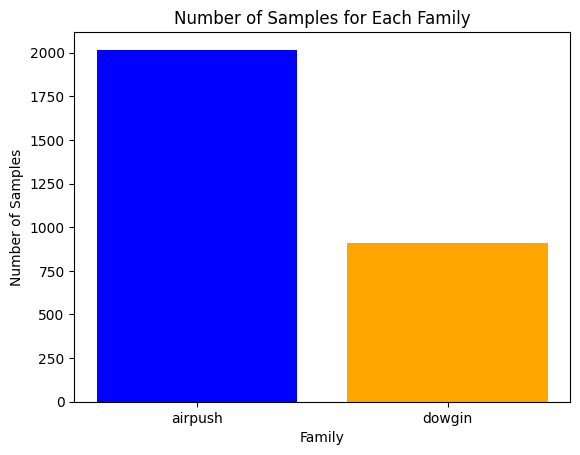

In [4]:
plt.bar(family_counts.index, family_counts.values, color=['blue', 'orange'])
plt.xlabel('Family')
plt.ylabel('Number of Samples')
plt.title('Number of Samples for Each Family')
plt.show()

In [5]:
df.drop(columns=['Hash', 'Category'], axis=1, inplace=True)

encoder = LabelEncoder()
df['Label'] = encoder.fit_transform(df['Family'])

df.drop(columns = 'Family' ,axis=1, inplace=True)
y = df['Label'] 
X = df.drop(columns = 'Label', axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [6]:
zero_variance_columns= df.columns[df.var() == 0]
print(zero_variance_columns)


df = df.drop(columns= zero_variance_columns)

correlation_matrix=np.corrcoef(df, rowvar=False, ddof=1)

Index(['Memory_SwapPssDirty', 'Memory_AssetManagers',
       'API_Process_android.os.Process_start',
       'API_Process_android.app.ActivityManager_killBackgroundProcesses',
       'API_JavaNativeInterface_java.lang.Runtime_loadLibrary',
       'API_JavaNativeInterface_java.lang.Runtime_load',
       'API_WebView_android.webkit.WebView_postUrl',
       'API_WebView_android.webkit.WebView_postWebMessage',
       'API_WebView_android.webkit.WebView_savePassword',
       'API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword',
       'API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword',
       'API_Database_android.database.sqlite.SQLiteDatabase_create',
       'API_IPC_android.content.ContextWrapper_sendStickyBroadcast',
       'API_DeviceInfo_android.net.wifi.WifiInfo_getNetworkId',
       'API_DeviceInfo_android.content.pm.PackageManager_getInstallerPackageName',
       'API_DeviceInfo_android.content.pm.PackageManager_getInstalledApplications',
       'API_Device

bias and ddof have no effect and are deprecated


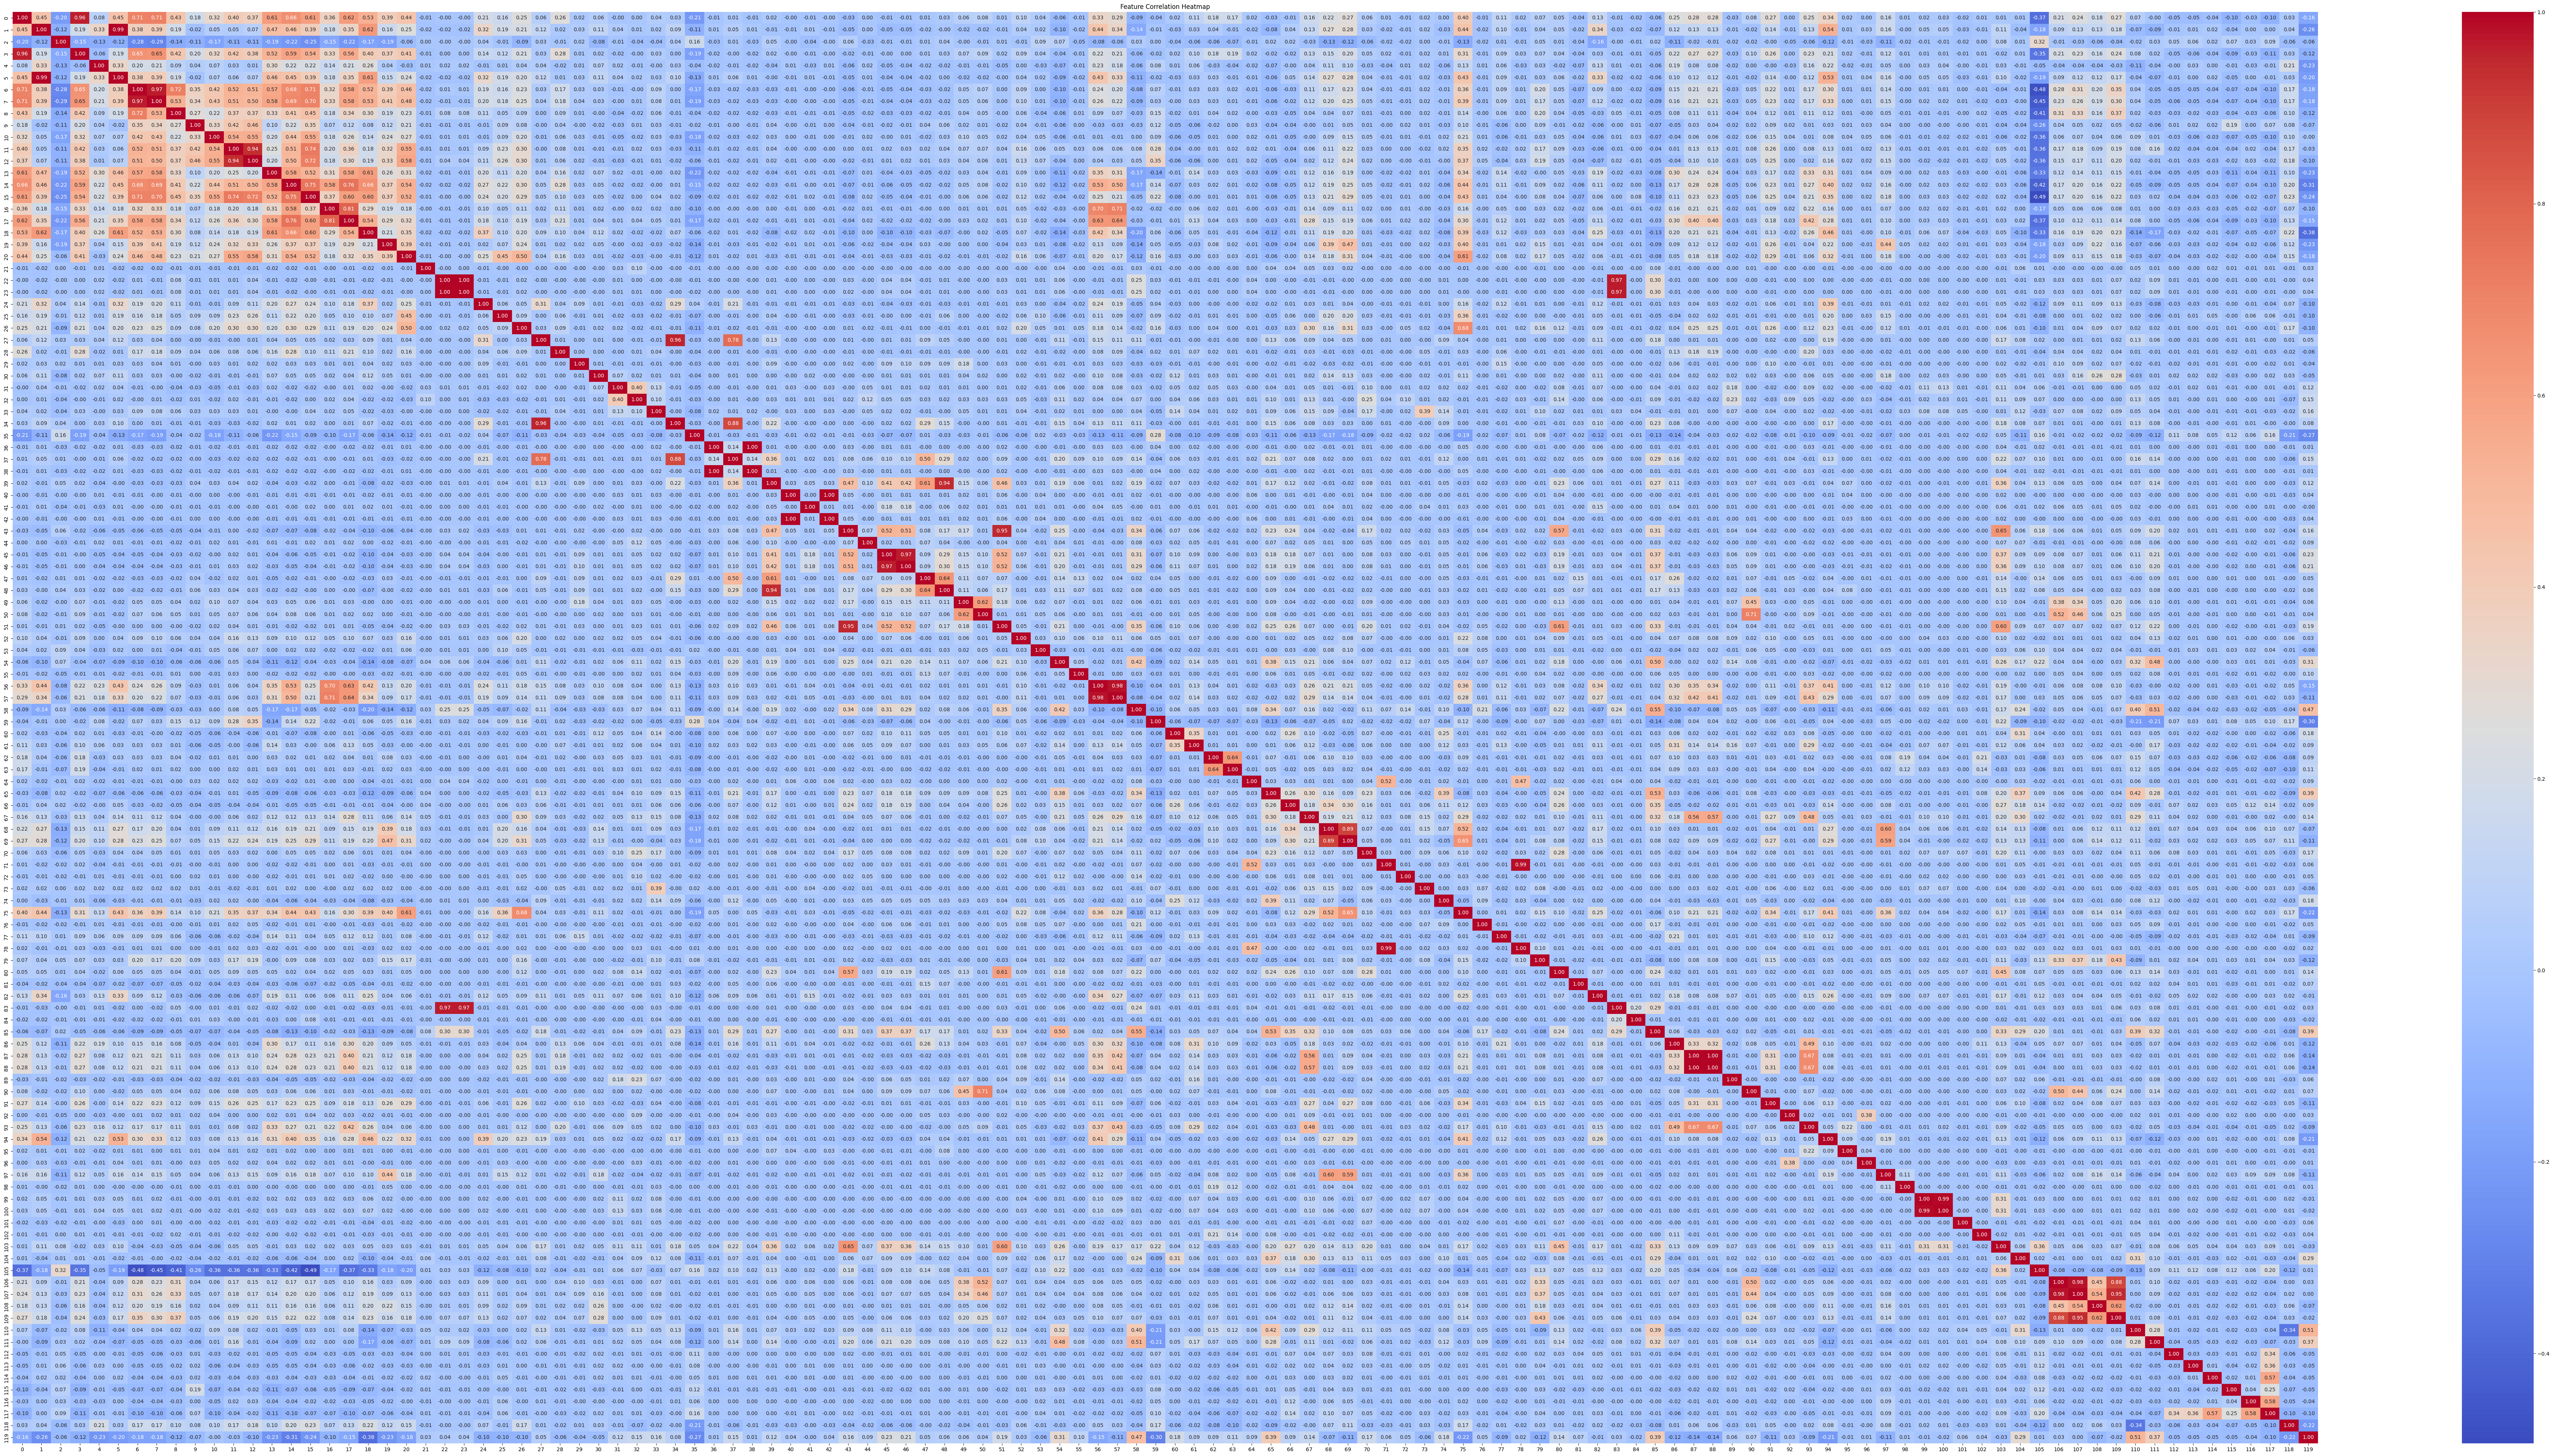

In [7]:
# plt.figure(figsize=(100,50))
# sns.heatmap(correlation_matrix,annot =True, fmt= ".2f", cmap= "coolwarm")
# plt.title("Feature Correlation Heatmap")
# plt.show()

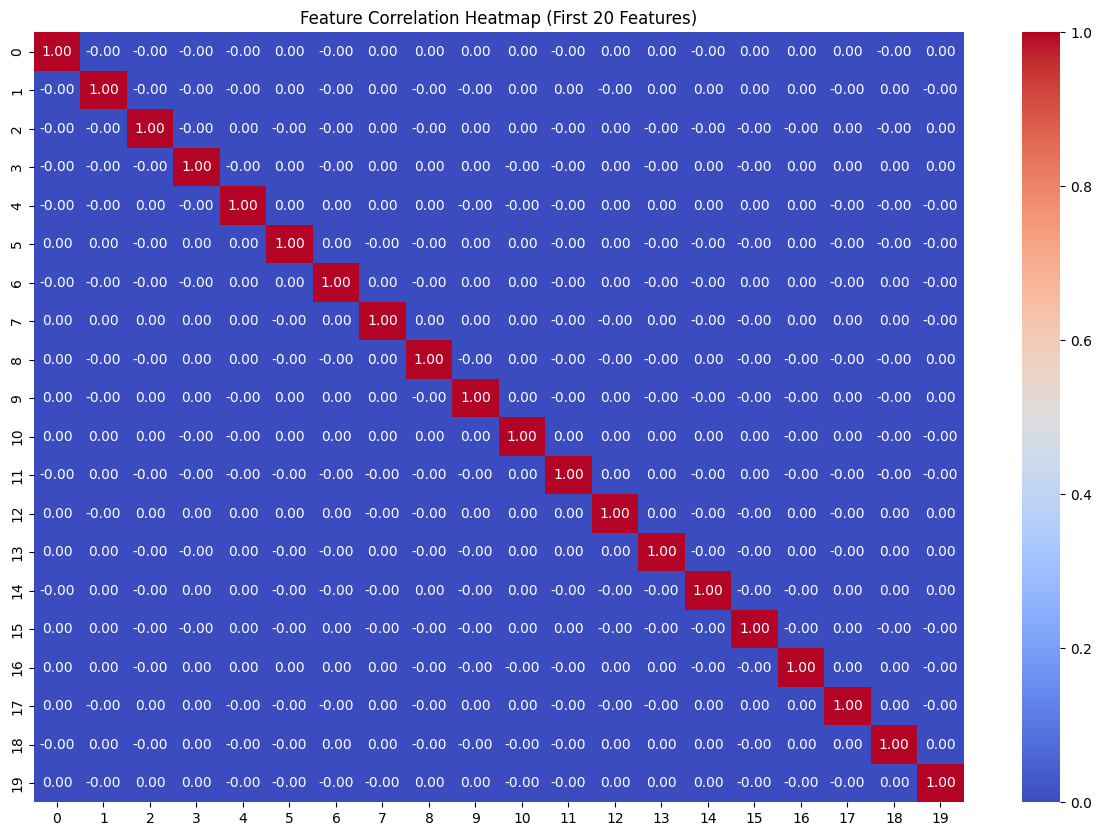

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the first 20 features from the correlation matrix
correlation_matrix_subset = correlation_matrix[:20, :20]

plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix_subset, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap (First 20 Features)")
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [9]:
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=30),
    'Logistic Regression': LogisticRegression(random_state=0),
    'Adaboost': AdaBoostClassifier()
}

param_grids = {
    'Random Forest': {'classifier__n_estimators': [50, 60, 57]},
    'Decision Tree': {'classifier__max_depth': [None, 10, 20, 30]},
    'Logistic Regression': {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Adaboost': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 1]}
}

selected_features_by_classifier = {}

for clf_name, clf in classifiers.items():
    pipeline = Pipeline([
        ('feature_selection', RFE(estimator=DecisionTreeClassifier(), n_features_to_select=56)),
        ('classifier', clf)
    ])

    param_grid = param_grids[clf_name]
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)

    grid_search.fit(X_train, y_train)

    best_rfe_estimator = grid_search.best_estimator_

    X_train_rfe = best_rfe_estimator.named_steps['feature_selection'].transform(X_train)
    X_test_rfe = best_rfe_estimator.named_steps['feature_selection'].transform(X_test)

    selected_features_by_classifier[clf_name] = np.where(best_rfe_estimator.named_steps['feature_selection'].support_)[0]

common_features = set(selected_features_by_classifier[next(iter(classifiers))])
for _, features in selected_features_by_classifier.items():
    common_features.intersection_update(features)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [10]:
common_features = list(common_features)
print(f"Common set of {len(common_features)} features selected by most classifiers: {common_features}")

Common set of 41 features selected by most classifiers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 130, 131, 13, 17, 18, 20, 132, 41, 43, 44, 64, 71, 76, 77, 78, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 96, 98, 105, 125]


In [11]:
X_train_rfe_selected = X_train[:, common_features] #selected the common features
X_test_rfe_selected = X_test[:, common_features]

In [12]:
pca_pipeline = Pipeline([
    ('pca', PCA()),
])

param_grid = {
    'pca__n_components': range(1,37),
}

grid_search = GridSearchCV(pca_pipeline, param_grid=param_grid, cv=5)

grid_search.fit(X_train_rfe_selected)

best_pca_estimator = grid_search.best_estimator_

X_train_pca = best_pca_estimator.transform(X_train_rfe_selected)
X_test_pca = best_pca_estimator.transform(X_test_rfe_selected)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'pca__n_components': 36}


In [13]:
pca_columns = [f'PC{i}' for i in range(1, grid_search.best_params_['pca__n_components']+ 1)]
df_x_train_pca_cic = pd.DataFrame(data=X_train_pca, columns=pca_columns)
df_x_train_pca_cic.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.247582 -0.386309 -0.054972  0.736684  0.300284  0.406179 -0.145968   
1 -3.386393 -0.753009  0.207747  0.478314  0.766376  0.489819 -0.025707   
2  1.599619 -0.424036  0.254122 -0.557420  1.737206 -0.988260 -0.708343   
3 -0.121193 -1.239749  0.258992  0.733522 -0.372172 -0.488075 -0.033382   
4 -0.759911 -0.917837  0.644334 -1.084838 -0.223896  0.668620  0.080236   

        PC8       PC9      PC10  ...      PC27      PC28      PC29      PC30  \
0  0.351498  0.102133 -0.063741  ...  0.120877  0.589394 -0.206006 -0.060225   
1  0.043055 -0.871671  0.518027  ... -0.076480 -0.017287  0.364599  0.218645   
2  0.729927 -0.485132  0.516234  ...  0.107272 -0.156392  0.272722 -0.266909   
3 -0.124643  0.111214  0.045402  ... -0.086259  0.065670  0.241465  0.100839   
4 -0.741155  0.182288 -0.558033  ...  0.122181 -0.074246 -0.077116  0.025951   

       PC31      PC32      PC33      PC34      PC35      PC36  
0 -0.003431  0.192142 -0.131260  0.420451  0.036508 -0.027161  
1  0.013546  0.014248 -0.049651 -0.019812 -0.021011 -0.006329  
2  0.390884  1.295444 -0.089209  0.137164  0.094031 -0.044518  
3  0.022641 -0.044925 -0.030774  0.010313  0.000599 -0.025581  
4 -0.045629 -0.033240 -0.050600  0.073892 -0.005111 -0.031995  

[5 rows x 36 columns]

In [14]:
explained_variance_ratio = best_pca_estimator.named_steps['pca'].explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [1.70322717e-01 8.19795905e-02 7.35749650e-02 6.25364117e-02
 5.27214758e-02 4.23901628e-02 3.94198005e-02 3.67551463e-02
 3.18911962e-02 3.10663113e-02 2.92728098e-02 2.84798864e-02
 2.72646341e-02 2.44934515e-02 2.35961436e-02 2.16972024e-02
 2.05736597e-02 2.03390328e-02 1.92005436e-02 1.83842856e-02
 1.77960040e-02 1.60914341e-02 1.43350953e-02 1.40402011e-02
 1.33495083e-02 1.15338629e-02 1.00884398e-02 9.11606639e-03
 8.85518684e-03 7.10659266e-03 6.20536392e-03 5.86055910e-03
 4.91663761e-03 3.04992659e-03 1.48060520e-03 1.13855026e-04]


In [15]:
cumulative_explained_variance_ratio = np.cumsum(best_pca_estimator.named_steps['pca'].explained_variance_ratio_)

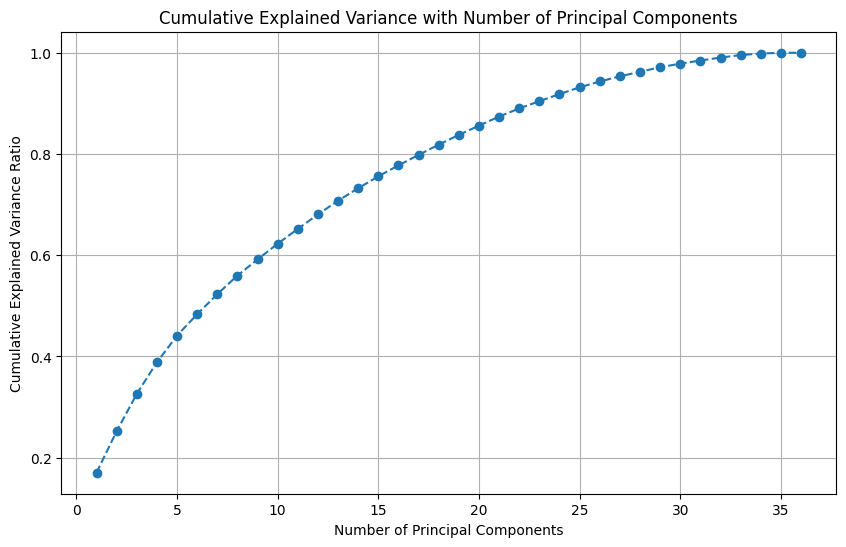

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance with Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [17]:
correlations, p_values = [], []
for feature_idx in range(X_train_pca.shape[1]):
    correlation, p_value = pearsonr(X_train_pca[:, feature_idx], y_train)
    correlations.append(correlation)
    p_values.append(p_value)

for feature_idx, (correlation, p_value) in enumerate(zip(correlations, p_values)):
    print(f"Feature {feature_idx + 1}: Correlation = {correlation:.4f}, p-value = {p_value:.4f}")

Feature 1: Correlation = -0.2646, p-value = 0.0000
Feature 2: Correlation = 0.4673, p-value = 0.0000
Feature 3: Correlation = -0.1004, p-value = 0.0000
Feature 4: Correlation = -0.3087, p-value = 0.0000
Feature 5: Correlation = -0.0397, p-value = 0.0550
Feature 6: Correlation = -0.0825, p-value = 0.0001
Feature 7: Correlation = -0.0264, p-value = 0.2019
Feature 8: Correlation = 0.1131, p-value = 0.0000
Feature 9: Correlation = 0.0974, p-value = 0.0000
Feature 10: Correlation = -0.0740, p-value = 0.0003
Feature 11: Correlation = 0.0333, p-value = 0.1073
Feature 12: Correlation = 0.0363, p-value = 0.0788
Feature 13: Correlation = -0.1098, p-value = 0.0000
Feature 14: Correlation = -0.1727, p-value = 0.0000
Feature 15: Correlation = -0.0106, p-value = 0.6080
Feature 16: Correlation = 0.0635, p-value = 0.0021
Feature 17: Correlation = 0.0102, p-value = 0.6205
Feature 18: Correlation = -0.0181, p-value = 0.3818
Feature 19: Correlation = -0.0342, p-value = 0.0985
Feature 20: Correlation = 0.

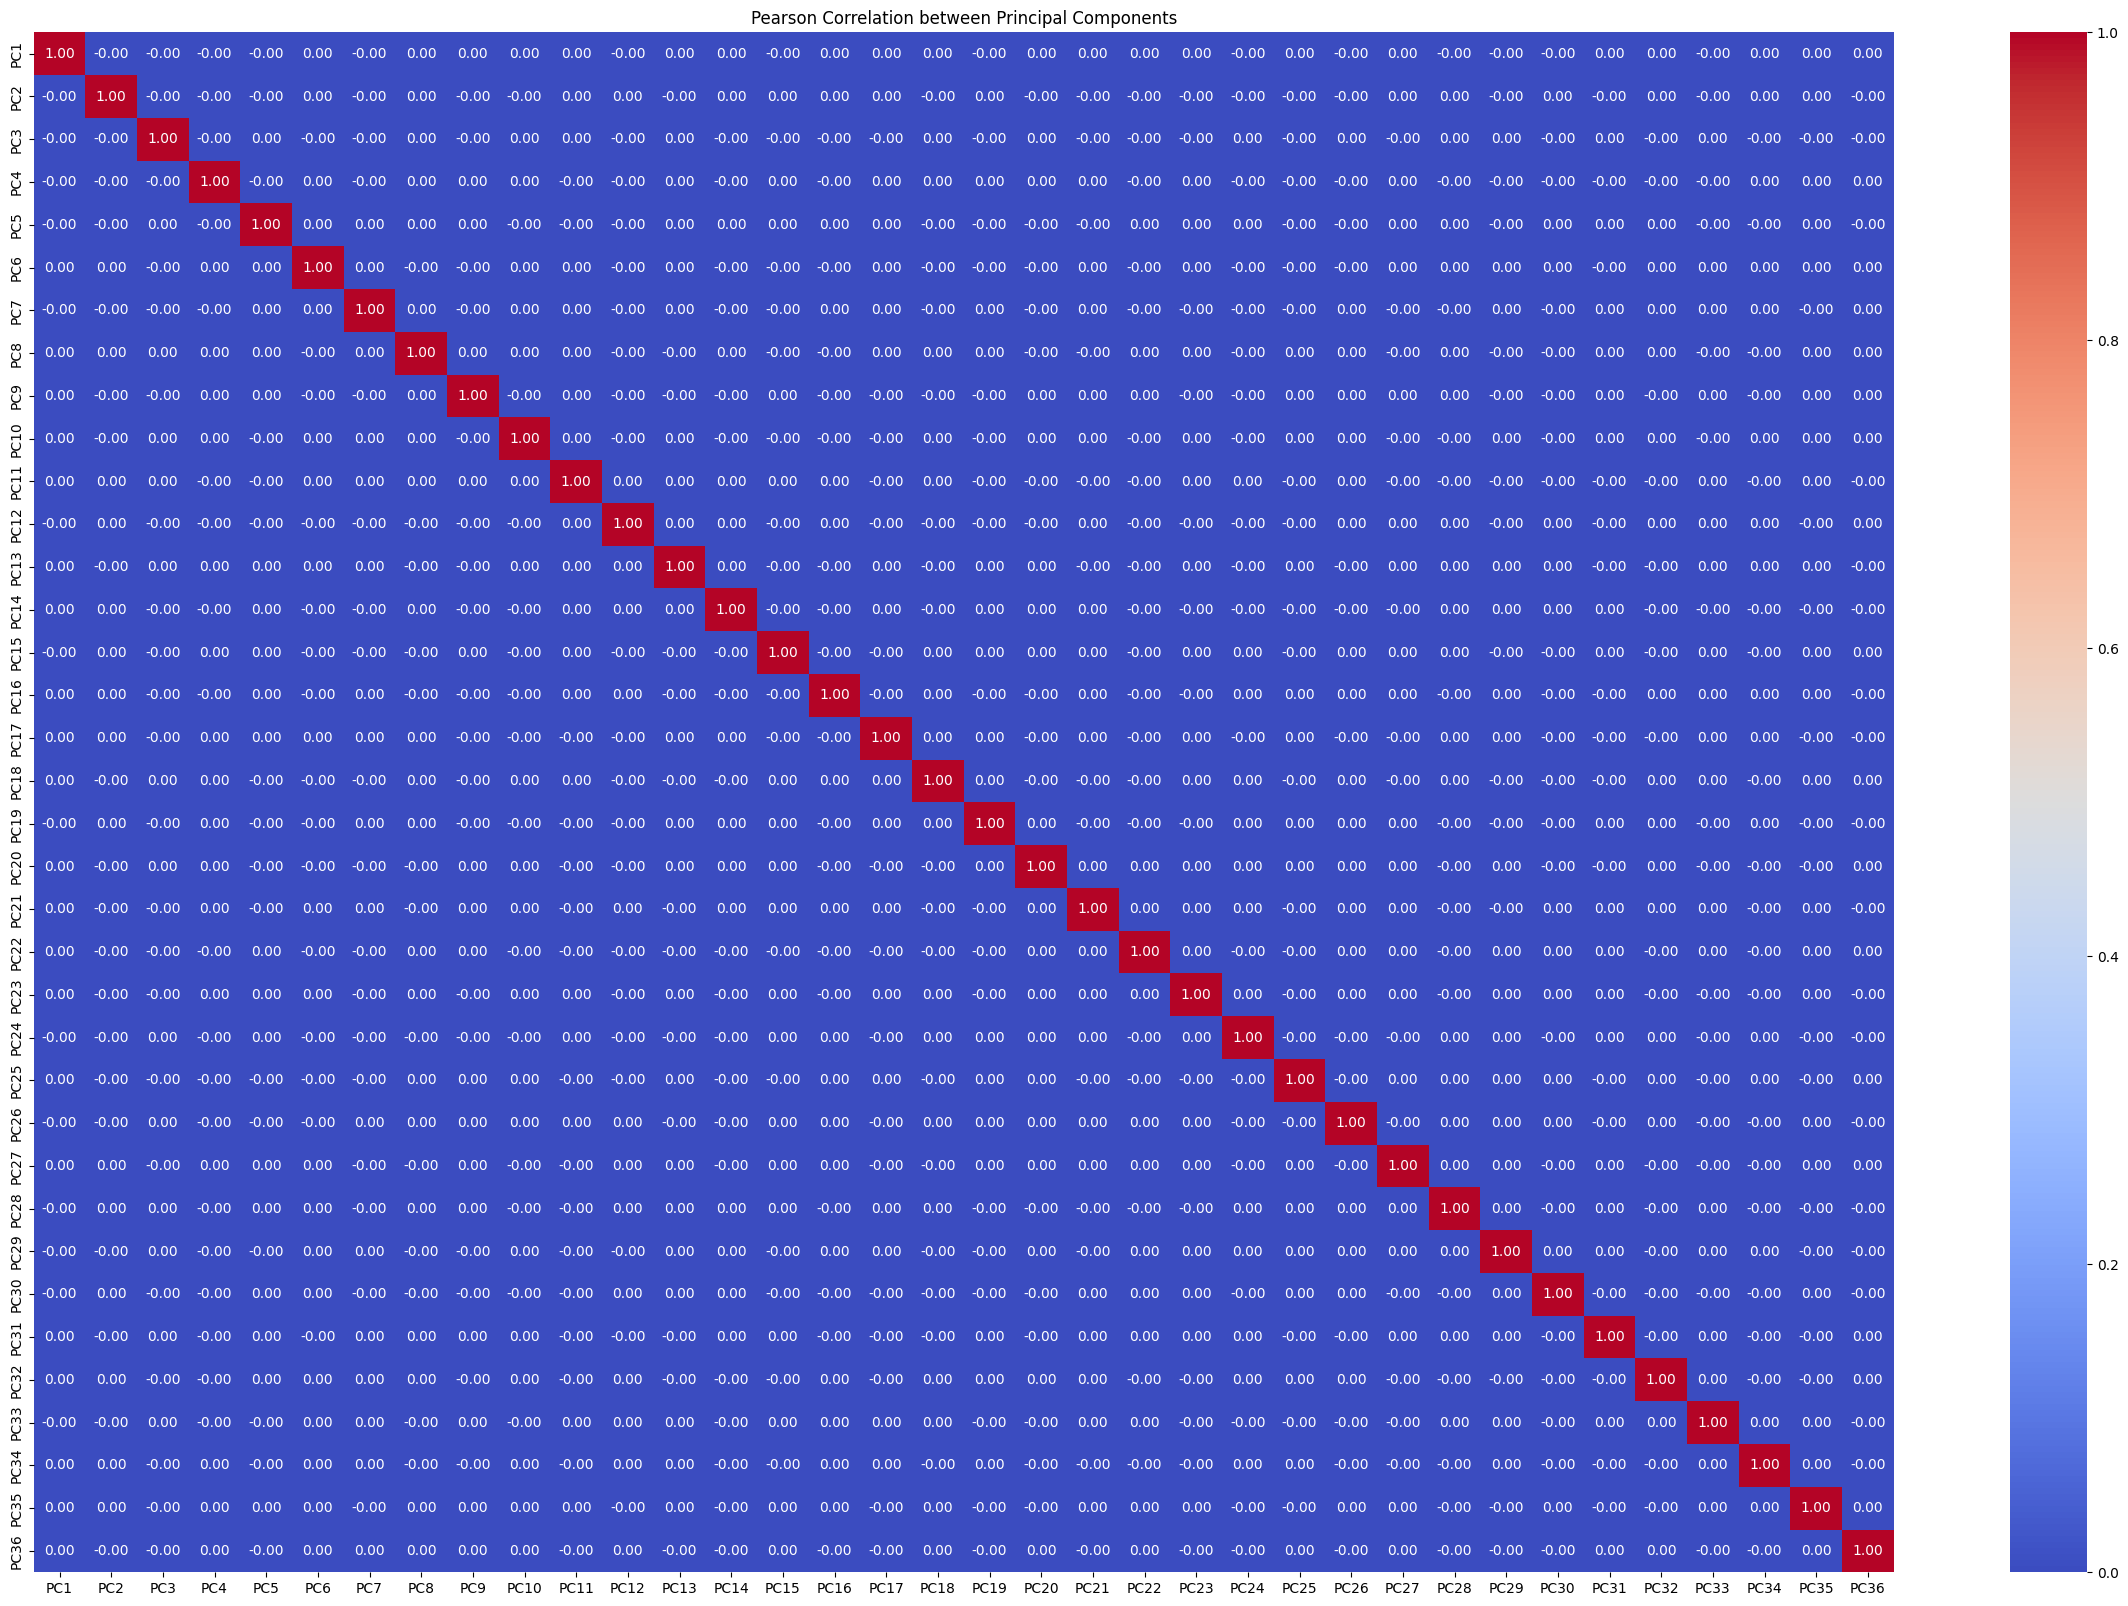

In [18]:
correlation_matrix = np.corrcoef(X_train_pca, rowvar=False)

plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=pca_columns, yticklabels=pca_columns)
plt.title("Pearson Correlation between Principal Components")
plt.show()

In [19]:
param_grid = {
    'max_depth': range(1, 50),
    'min_samples_leaf': range(1, 50)
}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for DT with Highest Accuracy Score:", best_params)
best_model = DecisionTreeClassifier(**best_params)
best_model.fit(X_train_pca, y_train)
y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Best Hyperparameters for DT with Highest Accuracy Score: {'max_depth': 10, 'min_samples_leaf': 4}
Accuracy: 0.90
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93       408
           1       0.87      0.79      0.83       178

    accuracy                           0.90       586
   macro avg       0.89      0.87      0.88       586
weighted avg       0.90      0.90      0.90       586



In [20]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for RF with Highest Accuracy Score:", best_params)
best_model = RandomForestClassifier(**best_params, criterion= 'entropy')
best_model.fit(X_train_pca, y_train)
y_pred = best_model.predict(X_test_pca)
accuracy_rf = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print('Random Forest Classification Report:\n', classification_report(y_test, y_pred))


360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lisaf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lisaf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\lisaf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\lisaf\AppData\Local\Programs\Python\Python311\

Best Hyperparameters for RF with Highest Accuracy Score: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Random Forest Accuracy: 0.94
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       408
           1       0.96      0.85      0.90       178

    accuracy                           0.94       586
   macro avg       0.95      0.92      0.93       586
weighted avg       0.94      0.94      0.94       586



In [21]:
param_grid = {
    'C': [10**i for i in range(-10,10)],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for LR with Highest Accuracy Score:", best_params)
# Make predictions on the test set using the best model
best_model = LogisticRegression(**best_params)
best_model.fit(X_train_pca, y_train)
y_pred_cic_lr = best_model.predict(X_test_pca)
accuracy_lr = accuracy_score(y_test, y_pred_cic_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')
print('Logistic Regression Classification Report:\n', classification_report(y_test, y_pred_cic_lr))

`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past be

Best Hyperparameters for LR with Highest Accuracy Score: {'C': 1e-10, 'penalty': 'none', 'solver': 'lbfgs'}
Logistic Regression Accuracy: 0.93
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       408
           1       0.90      0.88      0.89       178

    accuracy                           0.93       586
   macro avg       0.92      0.92      0.92       586
weighted avg       0.93      0.93      0.93       586



`penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
Setting penalty=None will ignore the C and l1_ratio parameters
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [22]:
param_grid = {
    'C': range(1, 50),
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))

}
grid_search = GridSearchCV(svm.SVC(kernel = 'linear'), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for SVM with Highest Accuracy Score:", best_params)
best_model =  svm.SVC(kernel='linear', **best_params)
best_model.fit(X_train_pca, y_train)
y_pred_cic_svm = best_model.predict(X_test_pca)
accuracy_svm = accuracy_score(y_test, y_pred_cic_svm)
print(f'Support Vector Machine Accuracy: {accuracy_svm:.2f}')
print('Support Vector Machine Classification Report:\n', classification_report(y_test, y_pred_cic_svm))

Best Hyperparameters for SVM with Highest Accuracy Score: {'C': 29, 'gamma': 'scale'}
Support Vector Machine Accuracy: 0.94
Support Vector Machine Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       408
           1       0.89      0.89      0.89       178

    accuracy                           0.94       586
   macro avg       0.92      0.92      0.92       586
weighted avg       0.94      0.94      0.94       586



In [23]:
param_grid = {
    'C': [1,2,3],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.1, 0.5]
}
grid_search = GridSearchCV(svm.SVC(kernel = 'rbf'), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for SVM with Highest Accuracy Score:", best_params)
best_model =  svm.SVC(kernel='rbf', **best_params)
best_model.fit(X_train_pca, y_train)
y_pred_cic_svm = best_model.predict(X_test_pca)
accuracy_svm = accuracy_score(y_test, y_pred_cic_svm)
print(f'Support Vector Machine Accuracy: {accuracy_svm:.2f}')
print('Support Vector Machine Classification Report:\n', classification_report(y_test, y_pred_cic_svm))

Best Hyperparameters for SVM with Highest Accuracy Score: {'C': 3, 'coef0': 0.0, 'degree': 2, 'gamma': 'auto'}
Support Vector Machine Accuracy: 0.95
Support Vector Machine Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       408
           1       0.93      0.92      0.92       178

    accuracy                           0.95       586
   macro avg       0.95      0.94      0.95       586
weighted avg       0.95      0.95      0.95       586



In [24]:
param_grid_knn = {
    'n_neighbors': range(1, 50),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for KNN with Highest Accuracy Score:", best_params)
best_model = KNeighborsClassifier(**best_params)
best_model.fit(X_train_pca, y_train)
y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Best Hyperparameters for KNN with Highest Accuracy Score: {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}
Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       408
           1       0.90      0.87      0.88       178

    accuracy                           0.93       586
   macro avg       0.92      0.91      0.91       586
weighted avg       0.93      0.93      0.93       586



In [25]:
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for GaussianNB with Highest Accuracy Score:", best_params)
best_model = GaussianNB(**best_params)
best_model.fit(X_train_pca, y_train)
y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Best Hyperparameters for GaussianNB with Highest Accuracy Score: {'var_smoothing': 1e-06}
Accuracy: 0.83
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.89       408
           1       0.82      0.56      0.66       178

    accuracy                           0.83       586
   macro avg       0.83      0.75      0.78       586
weighted avg       0.83      0.83      0.82       586



In [26]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
grid_search = GridSearchCV(xgb.XGBClassifier(), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for XGB with Highest Accuracy Score:", best_params)
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_pca, y_train)
y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Best Hyperparameters for XGB with Highest Accuracy Score: {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.6}
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       408
           1       0.97      0.88      0.92       178

    accuracy                           0.95       586
   macro avg       0.96      0.93      0.94       586
weighted avg       0.95      0.95      0.95       586



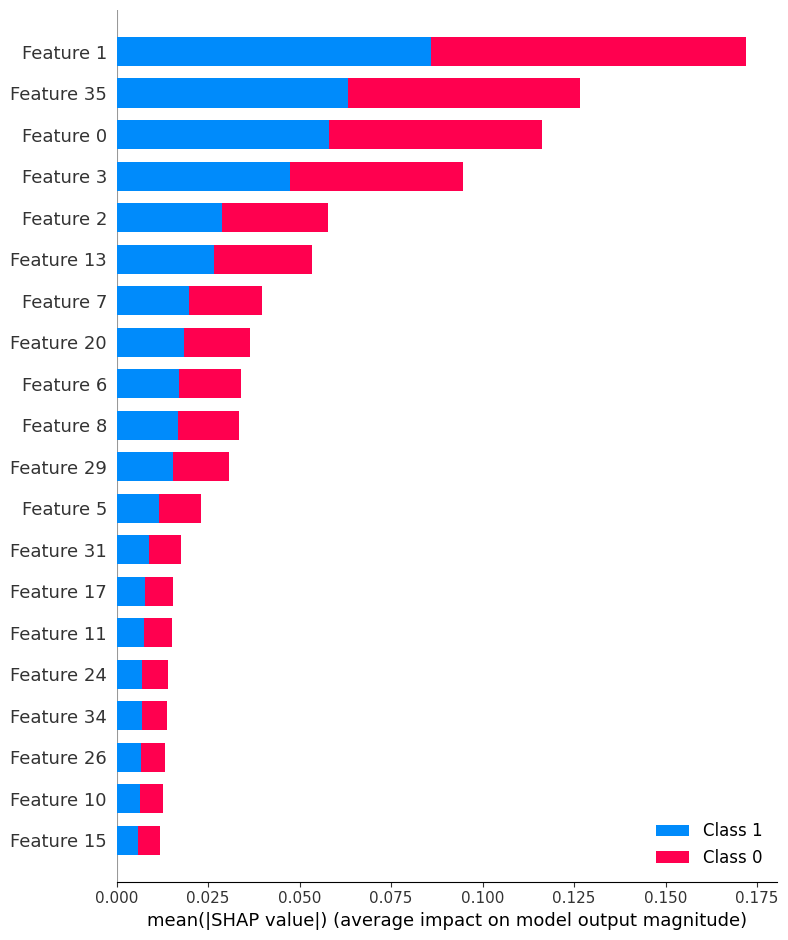

In [27]:
model = RandomForestClassifier(max_depth= 15, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split=2, n_estimators= 200)
model.fit(X_train_pca, y_train)

# Explain the model's predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_pca)

# Summary plot
shap.summary_plot(shap_values, X_test_pca)
# shap.plots.bar(shap_values)

In [28]:
categories = ['Airpush', 'Dowgin']  ----------ckdjncjnfdjvnd

NameError: name 'ckdjncjnfdjvnd' is not defined

Category: Airpush, Image Size: 433 x 433 pixels
Category: Dowgin, Image Size: 393 x 393 pixels


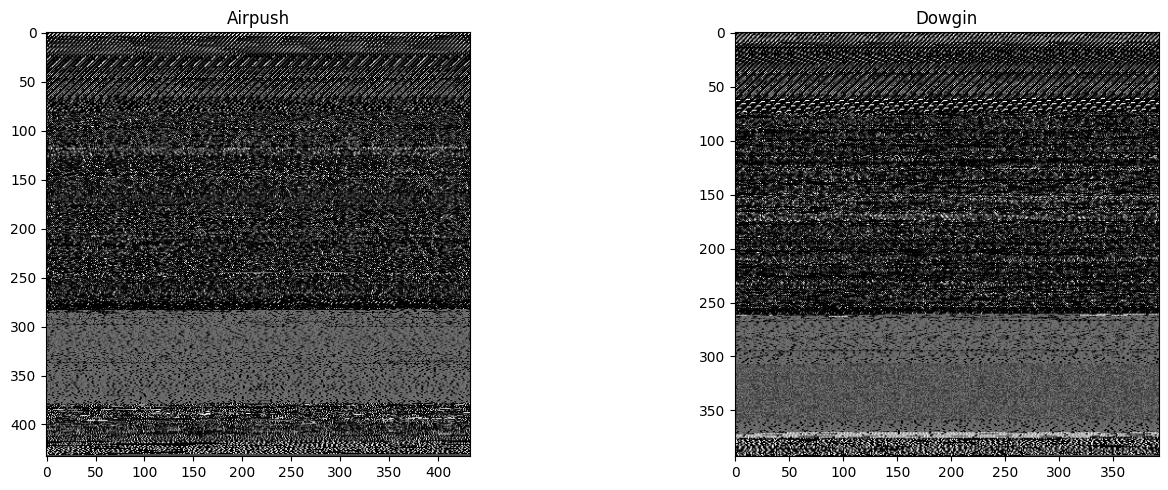

In [ ]:
import random


train_path = "image_models\\train\\"

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, category in enumerate(categories):
    category_folder = os.path.join(train_path, category)

    image_files = [f for f in os.listdir(category_folder) if f.endswith('.png')]

    random_image_file = random.choice(image_files)

    random_image_path = os.path.join(category_folder, random_image_file)

    random_image = Image.open(random_image_path)

    image_size = random_image.size

    print(f"Category: {category}, Image Size: {image_size[0]} x {image_size[1]} pixels")

    axes[i].imshow(random_image)

    axes[i].set_title(category)

plt.tight_layout()
plt.show()

In [ ]:
category_counts = {}

for category in categories:
    category_folder = os.path.join(train_path, category)
    image_files = [f for f in os.listdir(category_folder) if f.endswith('.png')]
    category_counts[category] = len(image_files)

for category, count in category_counts.items():
    print(f"{category}: {count} samples")

Airpush: 749 samples
Dowgin: 489 samples


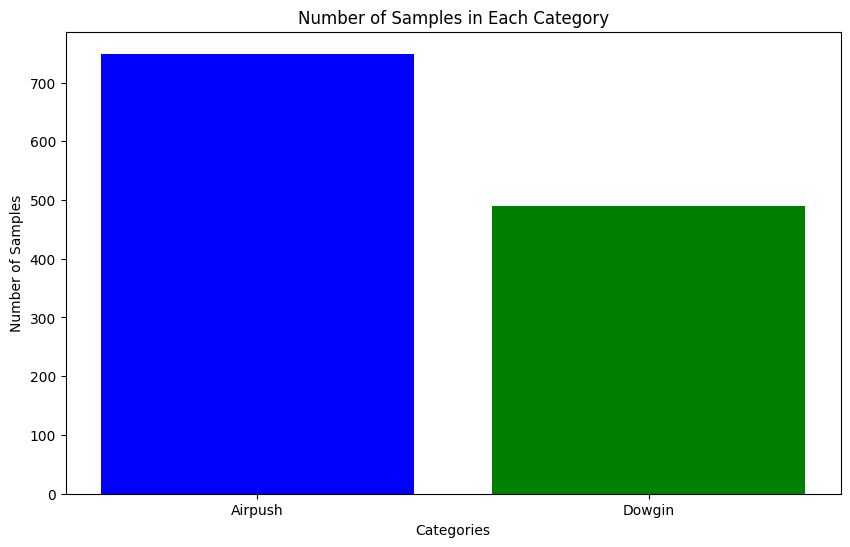

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(category_counts.keys(), category_counts.values(), color=['blue', 'green', 'red'])
ax.set_xlabel('Categories')
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Samples in Each Category')
plt.show()

In [ ]:
target_size = (258, 258)

resized_dir = r"android-work\resized"

categories = os.listdir(train_path)

# Loop through both train and validation directories
for dataset_path in [train_path, validation_path]:
    for category in categories:
        category_folder = os.path.join(dataset_path, category)
        resized_category_folder = os.path.join(resized_dir, category)

        os.makedirs(resized_category_folder, exist_ok=True)

        image_files = [f for f in os.listdir(category_folder) if f.endswith('.png')]

        for image_file in tqdm(image_files, desc=f"Processing {dataset_path}/{category}"):
            input_image_path = os.path.join(category_folder, image_file)
            output_image_path = os.path.join(resized_category_folder, image_file)

            image = Image.open(input_image_path)

            # Resize the image
            resized_image = image.resize(target_size)

            # Save the resized image
            resized_image.save(output_image_path)

print("Resizing complete.")

Processing image_models\val/Dowgin: 100%|██████████| 122/122 [00:02<00:00, 43.52it/s]

Resizing complete.


In [ ]:
normalized_dir = r"android-work\normalized" 

categories = os.listdir(resized_dir)

for category in categories:
    category_folder_resized = os.path.join(resized_dir, category)
    category_folder_normalized = os.path.join(normalized_dir, category)

    # Create the 'normalized' directory if it doesn't exist
    os.makedirs(category_folder_normalized, exist_ok=True)

    image_files = [f for f in os.listdir(category_folder_resized) if f.endswith('.png')]

    for image_file in image_files:
        input_image_path = os.path.join(category_folder_resized, image_file)
        output_image_path = os.path.join(category_folder_normalized, image_file)

        image = Image.open(input_image_path)

        image_array = np.array(image)

        normalized_image = (image_array / 127.5) - 1.0

        # Save the normalized image to the 'normalized' directory
        normalized_image = Image.fromarray((normalized_image * 127.5 + 127.5).astype(np.uint8))
        normalized_image.save(output_image_path)

print("Normalization complete.")

Normalization complete.


Category: Airpush, Image Size: 258 x 258 pixels
Category: Dowgin, Image Size: 258 x 258 pixels


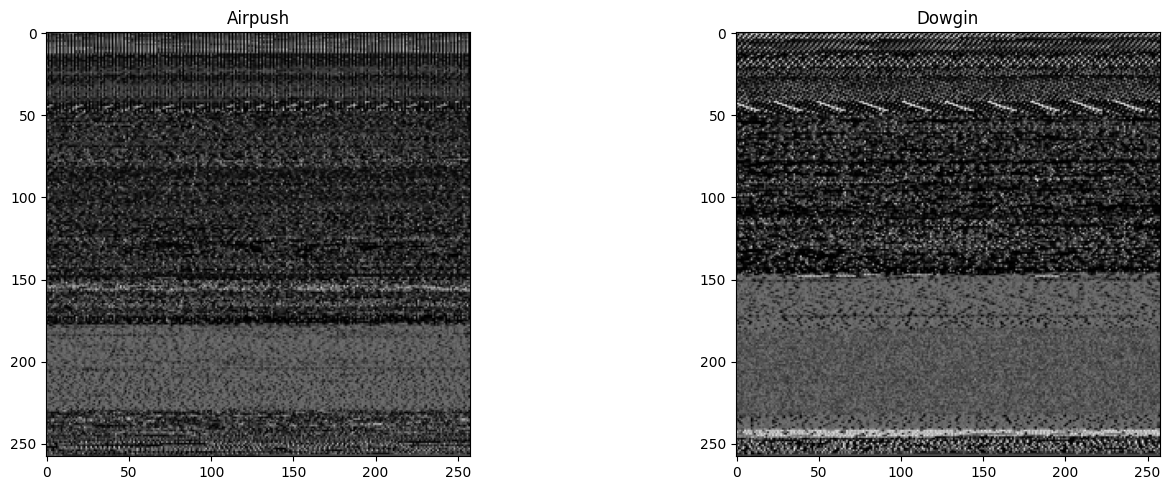

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, category in enumerate(categories):
    category_folder = os.path.join(normalized_dir, category)

    image_files = [f for f in os.listdir(category_folder) if f.endswith('.png')]

    random_image_file = random.choice(image_files)

    random_image_path = os.path.join(category_folder, random_image_file)

    random_image = Image.open(random_image_path)

    image_size = random_image.size

    print(f"Category: {category}, Image Size: {image_size[0]} x {image_size[1]} pixels")

    axes[i].imshow(random_image)

    axes[i].set_title(category)

plt.tight_layout()
plt.show()

In [ ]:
import gc
gc.collect()

0

In [ ]:
img_train_dir = r"android-work\normalized"
img_test_dir = r"android-work\test"


def load_images_from_directory(directory, target_size=(258, 258)):
    images = []
    labels = []

    class_folders = os.listdir(directory)

    class_label_mapping = {class_folder: i for i, class_folder in enumerate(class_folders)}

    for i, class_folder in enumerate(class_folders):

        class_path = os.path.join(directory, class_folder)

        for image_file in os.listdir(class_path):
            if image_file.endswith('.png'):
                image_path = os.path.join(class_path, image_file)

                img = Image.open(image_path)
                img_array = np.array(img)

                # Resize the image while maintaining the original aspect ratio
                img_resized = resize(img_array, target_size, anti_aliasing=True)

                images.append(img_resized)
                labels.append(i)

    # Print class name to label mapping (excluding the specified class)
    print("Class Name to Label Mapping")
    for class_name, label in class_label_mapping.items():
            print(f"{class_name}: {label}")

    return np.array(images), np.array(labels)
train_images, train_labels = load_images_from_directory(img_train_dir)
test_images, test_labels = load_images_from_directory(img_test_dir)


In [ ]:
input_shape = (258, 258, 3)
# the only change 

image_model = Sequential()

image_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
image_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
image_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))

image_model.add(MaxPooling2D(pool_size=(5, 5)))
image_model.add(MaxPooling2D(pool_size=(5, 5)))

image_model.add(Flatten())

image_model.add(Dense(X_train_pca.shape[1], activation='relu'))

# Output layer
num_classes = 2
image_model.add(Dense(num_classes, activation='softmax'))

In [ ]:
image_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 254, 254, 64)      4864      
                                                                 
 conv2d_34 (Conv2D)          (None, 250, 250, 64)      102464    
                                                                 
 conv2d_35 (Conv2D)          (None, 246, 246, 64)      102464    
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 49, 49, 64)        0         
 ng2D)                                                           
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 9, 9, 64)          0         
 ng2D)                                                           
                                                                 
 flatten_19 (Flatten)        (None, 5184)            

In [ ]:
# Compile the model
image_model.compile(loss='categorical_crossentropy',  optimizer='adam',metrics=['accuracy'])

In [ ]:
# One-hot encode the labels
num_classes = len(np.unique(train_labels))
train_labels_one_hot = to_categorical(train_labels, num_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes)

In [ ]:
X_train_images, X_val_images, y_train_images, y_val_images = train_test_split(train_images, train_labels_one_hot, test_size=0.2, random_state=42)

In [ ]:
epochs = 10 
batch_size = 32  

history_img = image_model.fit(X_train_images, y_train_images, epochs=epochs, batch_size=batch_size, validation_data=(X_val_images, y_val_images))

Epoch 1/10
39/39 [==============================] - 395s 10s/step - loss: 0.6781 - accuracy: 0.5909 - val_loss: 0.6251 - val_accuracy: 0.6194
Epoch 2/10
39/39 [==============================] - 386s 10s/step - loss: 0.4897 - accuracy: 0.7526 - val_loss: 0.3292 - val_accuracy: 0.8710
Epoch 3/10
39/39 [==============================] - 388s 10s/step - loss: 0.3039 - accuracy: 0.8876 - val_loss: 0.3597 - val_accuracy: 0.8710
Epoch 4/10
39/39 [==============================] - 426s 11s/step - loss: 0.2312 - accuracy: 0.9022 - val_loss: 0.1445 - val_accuracy: 0.9226
Epoch 5/10
39/39 [==============================] - 383s 10s/step - loss: 0.1828 - accuracy: 0.9224 - val_loss: 0.1126 - val_accuracy: 0.9419
Epoch 6/10
39/39 [==============================] - 387s 10s/step - loss: 0.1134 - accuracy: 0.9483 - val_loss: 0.0832 - val_accuracy: 0.9677
Epoch 7/10
39/39 [==============================] - 385s 10s/step - loss: 0.0990 - accuracy: 0.9507 - val_loss: 0.0719 - val_accuracy: 0.9774
Epoch 

In [ ]:
test_loss, test_accuracy = image_model.evaluate(test_images, test_labels_one_hot)
print(f'Test accuracy: {test_accuracy}')

13/13 [==============================] - 21s 2s/step - loss: 0.1698 - accuracy: 0.9534
Test accuracy: 0.9533678889274597


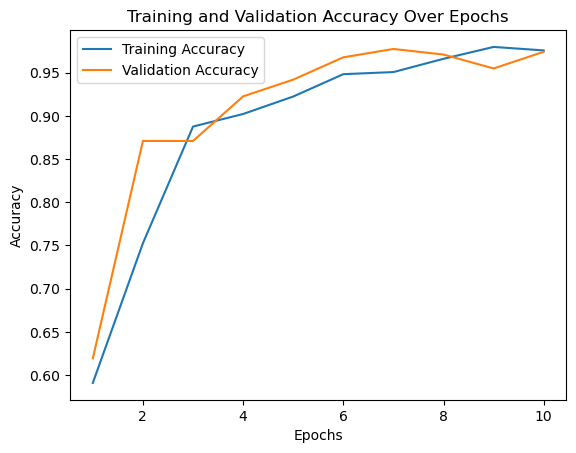

In [ ]:
train_accuracy = history_img.history['accuracy']
val_accuracy = history_img.history['val_accuracy']

epochs_range = range(1, epochs + 1)

# Plotting the training and validation accuracy
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
X_train_images_resized= np.array([cv2.resize(image,(128,128)) for image in X_train_images])


MemoryError: Unable to allocate 878. MiB for an array with shape (2341, 128, 128, 3) and data type float64

In [ ]:
y_train_images = np.array(y_train_images)

# indices to sort y_train_images
sorted_indices = np.argsort(y_train_images)

# sort X_train_images and y_train_images
X_train_images_resized = X_train_images_resized[sorted_indices]
y_train_images = y_train_images[sorted_indices]

In [ ]:
y_train = np.array(y_train)

# indices to sort y_train_images
sorted_indices = np.argsort(y_train)

# sort X_train_images and y_train_images
X_train_pca = X_train_pca[sorted_indices]
y_train = y_train[sorted_indices]

In [ ]:
# Get the number of samples in X_train_images
num_samples = X_train_images_resized.shape[0]

# Randomly select a subset of X_train_pca and y_train
indices = np.random.choice(X_train_pca.shape[0], size=num_samples, replace=False)
X_train_pca_subset = X_train_pca[indices]
y_train_subset = y_train[indices]

In [ ]:
# Define the tabular input
tabular_input = Input(shape=(X_train_pca.shape[1],), name='tabular_input')
tabular_dense = Dense(32, activation='relu')(tabular_input)

# Define the image input
image_input = Input(shape=(128, 128, 3), name='image_input')
conv_layer = layers.Conv2D(16, kernel_size=(3, 3), activation='relu')(image_input)
flatten_layer = Flatten()(conv_layer)

# Concatenate the outputs of tabular and image models
concatenated = layers.Concatenate()([tabular_dense, flatten_layer])

# Create a common feedforward neural network
common_dense = Dense(64, activation='relu')(concatenated)
output_layer = Dense(1, activation='sigmoid')(common_dense)

# Create the final model
model = Model(inputs=[tabular_input, image_input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit([X_train_pca_subset, X_train_images_resized], y_train_subset, epochs=10, batch_size=16)

Epoch 1/10
147/147 [==============================] - 30s 193ms/step - loss: 0.8150 - accuracy: 0.6446
Epoch 2/10
147/147 [==============================] - 28s 190ms/step - loss: 0.5917 - accuracy: 0.6877
Epoch 3/10
147/147 [==============================] - 29s 194ms/step - loss: 0.5685 - accuracy: 0.6916
Epoch 4/10
147/147 [==============================] - 29s 198ms/step - loss: 0.5459 - accuracy: 0.7155
Epoch 5/10
147/147 [==============================] - 29s 200ms/step - loss: 0.5262 - accuracy: 0.7266
Epoch 6/10
147/147 [==============================] - 29s 197ms/step - loss: 0.5160 - accuracy: 0.7240
Epoch 7/10
147/147 [==============================] - 29s 199ms/step - loss: 0.5055 - accuracy: 0.7283
Epoch 8/10
147/147 [==============================] - 29s 196ms/step - loss: 0.4941 - accuracy: 0.7330
Epoch 9/10
147/147 [==============================] - 29s 195ms/step - loss: 0.4845 - accuracy: 0.7343
Epoch 10/10
147/147 [==============================] - 28s 192ms/step - l

In [ ]:
X_test_images_resized= np.array([cv2.resize(image,(128,128)) for image in test_images])
print(X_test_images_resized.shape)

(386, 128, 128, 3)


In [ ]:
y_test_images = np.array(test_labels_one_hot)

# indices to sort y_train_images
sorted_indices = np.argsort(test_labels_one_hot)

# sort X_train_images and y_train_images
X_test_images_resized = X_test_images_resized[sorted_indices]
y_test_images = y_test_images[sorted_indices]

In [ ]:
y_test = np.array(y_test)

# indices to sort y_train_images
sorted_indices = np.argsort(y_test)

# sort X_train_images and y_train_images
X_test_pca = X_test_pca[sorted_indices]
y_test = y_test[sorted_indices]

In [ ]:
num_samples = X_test_images_resized.shape[0]

indices = np.random.choice(X_test_pca.shape[0], size=num_samples, replace=False)
X_test_pca_subset = X_test_pca[indices]
y_test_subset = y_test[indices]

In [ ]:
loss, accuracy = model.evaluate([X_test_pca_subset, X_test_images_resized], y_test_subset)
print(f'Test accuracy: {accuracy}')

13/13 [==============================] - 1s 29ms/step - loss: 0.6575 - accuracy: 0.6503
Test accuracy: 0.6502590775489807
